# Code: mnist_batchnorm

lab-09_6_mnist_batchnorm.ipynb

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

device: cuda


In [3]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw


Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [7]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [8]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu, 
                           linear2, bn2, relu, 
                           linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu, 
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [9]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [12]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
  bn_model.train() # set the model to train mode (dropout=True)

  for X, Y in train_loader:
    # reshape input image into [batch_size by 784]
    # label is not one-hot encoded
    X = X.view(-1, 28 * 28).to(device)
    Y = Y.to(device)

    bn_optimizer.zero_grad()
    bn_prediction = bn_model(X)
    bn_loss = criterion(bn_prediction, Y)
    bn_loss.backward()
    bn_optimizer.step()

    nn_optimizer.zero_grad()
    nn_prediction = nn_model(X)
    nn_loss = criterion(nn_prediction, Y)
    nn_loss.backward()
    nn_optimizer.step()

  with torch.no_grad():
    bn_model.eval() # set the model to evaluation mode

    # Test the model using train sets
    bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    for i, (X, Y) in enumerate(train_loader):
      X = X.view(-1, 28*28).to(device)
      Y = Y.to(device)

      bn_prediction = bn_model(X)
      bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
      bn_loss += criterion(bn_prediction, Y)
      bn_acc += bn_correct_prediction.float().mean()

      nn_prediction = nn_model(X)
      nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
      nn_loss += criterion(nn_prediction, Y)
      nn_acc += nn_correct_prediction.float().mean()
    
    bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

    # Save train losses/acc
    train_losses.append([bn_loss, nn_loss])
    train_accs.append([bn_acc, nn_acc])
    print('[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss: %.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' %
          ((epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
    
    # Test the model using test sets
    bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
    for i, (X, Y) in enumerate(test_loader):
      X = X.view(-1, 28*28).to(device)
      Y = Y.to(device)

      bn_prediction = bn_model(X)
      bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
      bn_loss += criterion(bn_prediction, Y)
      bn_acc += bn_correct_prediction.float().mean()

      nn_prediction = nn_model(X)
      nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
      nn_loss += criterion(nn_prediction, Y)
      nn_acc += nn_correct_prediction.float().mean()
    
    bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

    # Save valid losses/acc
    valid_losses.append([bn_loss, nn_loss])
    valid_accs.append([bn_acc, nn_acc])
    print('[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss: %.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' %
          ((epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
    print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss: 0.04222(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.10036(nn_acc:0.97)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss: 0.08503(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17076(nn_acc:0.96)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss: 0.04155(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.10171(nn_acc:0.97)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss: 0.08178(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.17230(nn_acc:0.96)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss: 0.03955(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.10148(nn_acc:0.97)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss: 0.08782(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17513(nn_acc:0.96)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss: 0.03567(bn_acc:0.99) vs No Batchnorm Loss(Acc): nn_loss:0.10910(nn_acc:0.97)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss: 0.08123(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.19357(nn_acc:0.95)

[Epoch 5-TRA

cf) function annotation  
https://bluese05.tistory.com/78

In [13]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
  bn = [i[0] for i in loss_list]
  nn = [i[1] for i in loss_list]

  plt.figure(figsize=(15, 10))
  plt.plot(bn, label='With BN')
  plt.plot(nn, label='Without BN')

  if ylim:
    plt.ylim(ylim)
  if title:
    plt.title(title)
    
  plt.legend()
  plt.grid('on')
  plt.show()

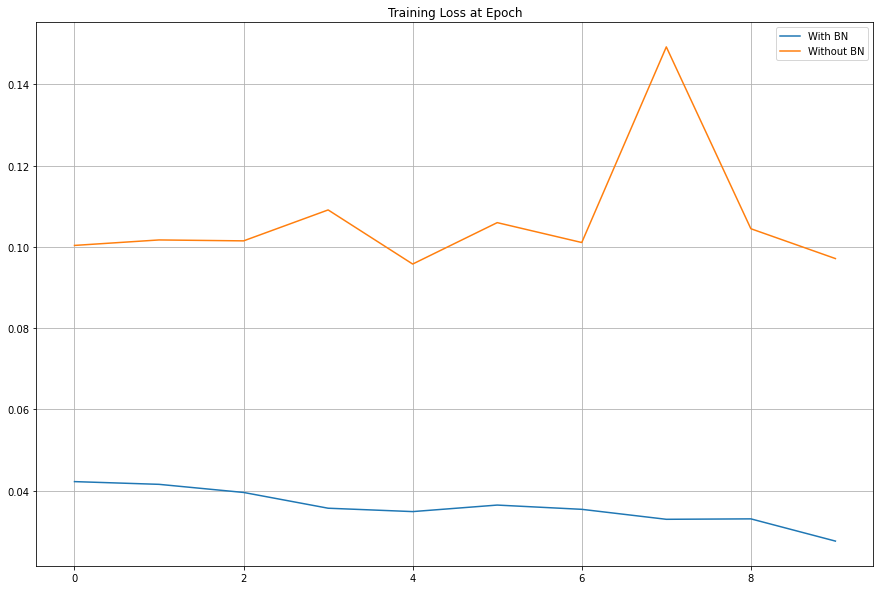

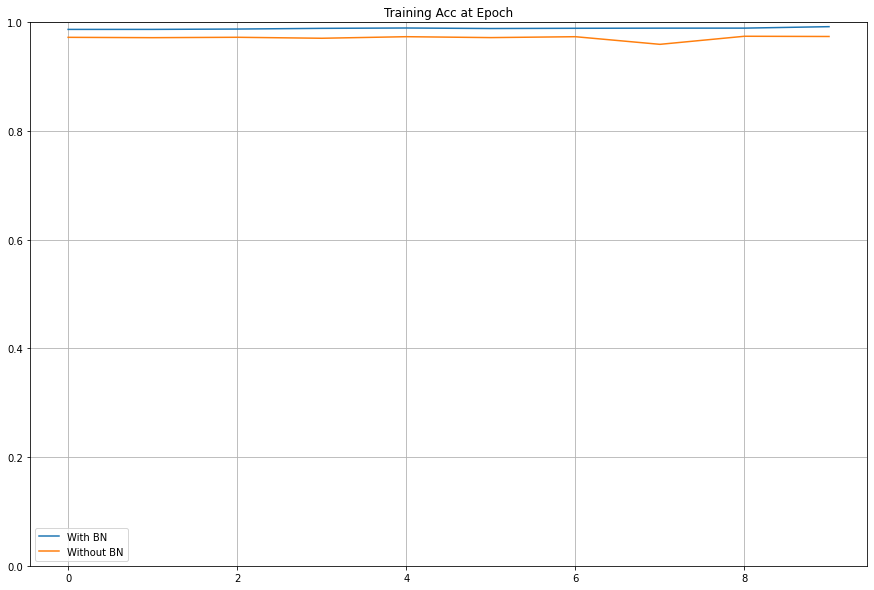

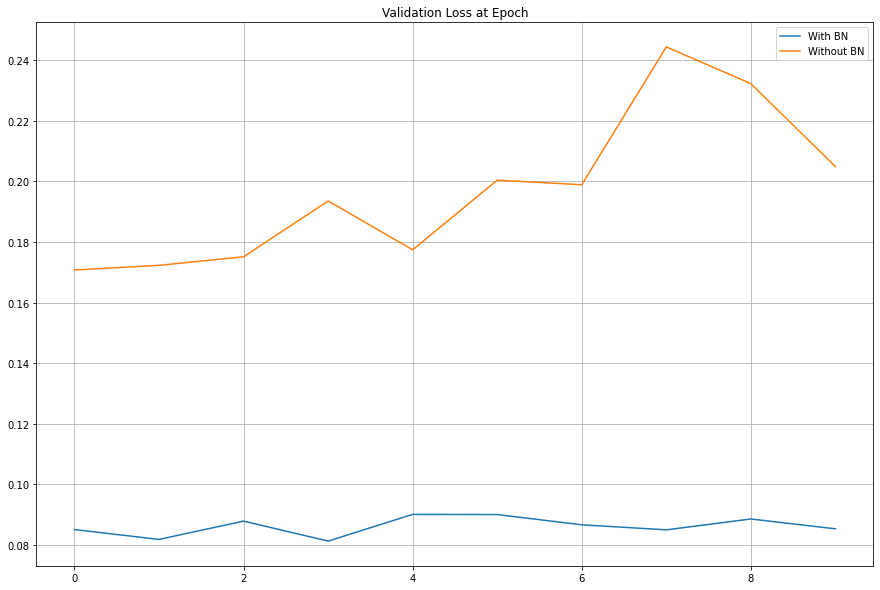

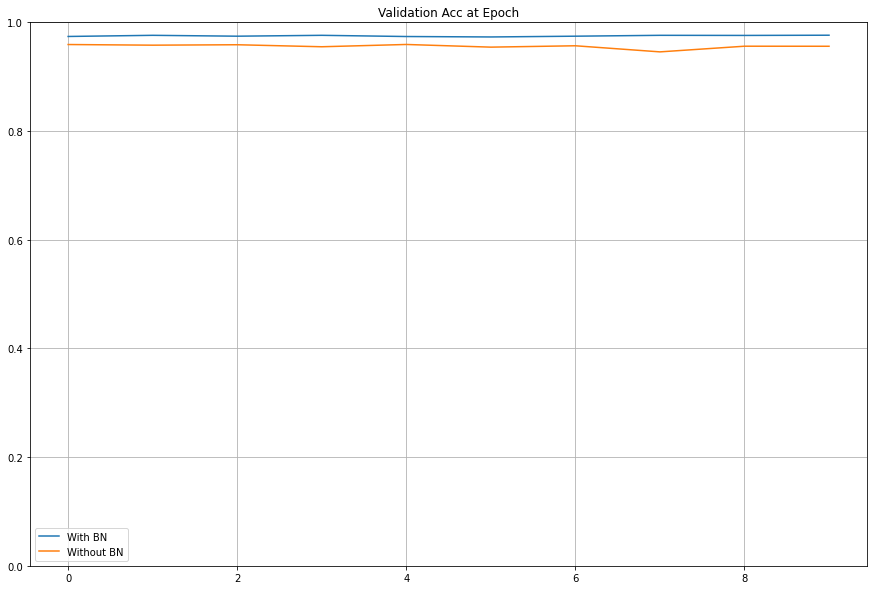

In [16]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')

plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')